In [0]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
data/                loaddata.ipynb  ML_angle.ipynb  others/
DeadReckoning.ipynb  makedata.ipynb  ML.ipynb        __pycache__/
graph/               ML2.ipynb       model/          scripts/


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('/content/drive/My Drive/卒業研究'
                '/DeadReckoning_ExperimentalData/ML/scripts')
import loaddata as ld

Index(['acc_linearX[m/s^2]', 'acc_linearY[m/s^2]', 'acc_linearZ[m/s^2]',
       'accX[m/s^2]', 'accY[m/s^2]', 'accZ[m/s^2]', 'gyroX[rad/s]',
       'gyroY[rad/s]', 'gyroZ[rad/s]', 'angleX[rad]', 'angleY[rad]',
       'angleZ[rad]', 'step', 'angleX[deg]', 'angleY[deg]', 'angleZ[deg]',
       'gyroX[deg/s]', 'gyroY[deg/s]', 'gyroZ[deg/s]', 'angleX[rad/s]',
       'angleY[rad/s]', 'angleZ[rad/s]', 'angleX[deg/s]', 'angleY[deg/s]',
       'angleZ[deg/s]'],
      dtype='object')
Index(['latitude(deg)', 'longitude(deg)', 'speed[m/s]', 'angle[rad]',
       'omega[rad/s]', 'x', 'y', 'speed_1Hz[m/s]', 'omega_1Hz[rad/s]',
       'angle[deg]', 'omega[deg/s]', 'omega_1Hz[deg/s]'],
      dtype='object')


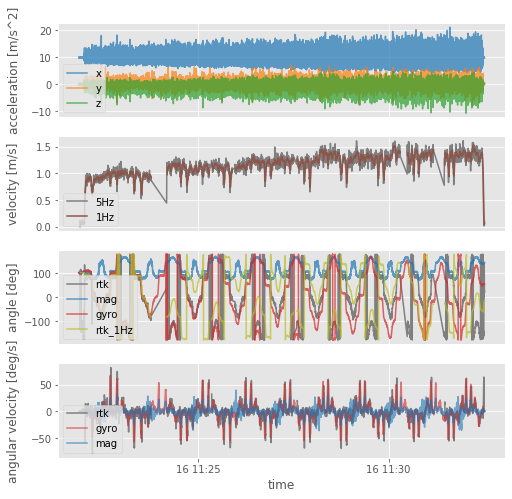

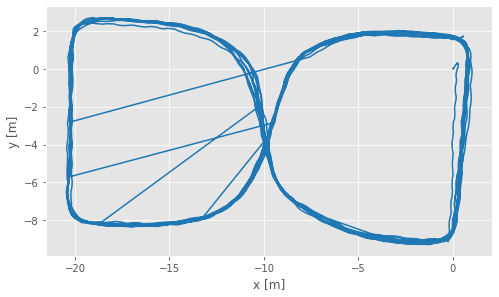

In [0]:
# データ読み込み
# directory = 'data/191211_1649'
# directory = 'data/200116_1104'
directory = 'data/200116_1121'
df_acc = ld.loadAccData(directory+'/acc.csv')
df_rtk = ld.loadRTKData(directory+'/rtk.csv')
df_acc, df_rtk = ld.fitData(df_acc, df_rtk)
ld.plot(df_acc, df_rtk)

print(df_acc.keys())
print(df_rtk.keys())

In [0]:
# GPSデータの読み込み
df_gps = ld.loadGPSData(directory+'/gps.csv',
                        df_rtk['latitude(deg)'][0],
                        df_rtk['longitude(deg)'][0])
df_gps = df_gps[df_acc.index[0]:]
print(df_gps.keys())

Index(['latitude', 'longitude', 'speed[m/s]', 'angle[rad]', 'angle[deg]', 'x',
       'y'],
      dtype='object')


In [0]:
from tensorflow import keras

# 歩幅推定
def speed_estimation(modelfilename, df_acc):
    model = keras.models.load_model(modelfilename)

    acc_list = []
    for t in tqdm(range(50, df_acc.shape[0])):
        acc_x = df_acc['accX[m/s^2]'][t-50 : t]
        acc_y = df_acc['accY[m/s^2]'][t-50 : t]
        acc_z = df_acc['accZ[m/s^2]'][t-50 : t]
        acc = np.concatenate([acc_x, acc_y, acc_z])
        acc /= 9.8
        acc_list.append(acc)

    acc_list = np.array(acc_list)
    speed = model.predict(acc_list)

    speed = np.reshape(speed, speed.shape[0])
    speed2 = np.concatenate([[0.0 for i in range(50)], speed])
    df_acc['speed'] = speed2

speed_estimation('model/my_model.h5', df_acc)

100%|██████████| 31941/31941 [00:22<00:00, 1441.07it/s]


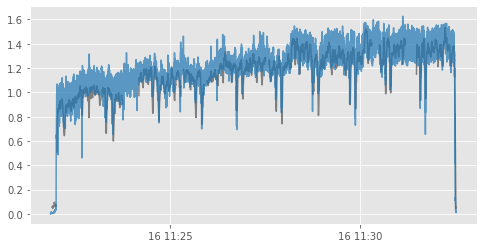

In [0]:
plt.figure(figsize=(8, 4))
plt.plot(df_rtk['speed_1Hz[m/s]'], color='tab:gray')
plt.plot(df_acc['speed'], color='tab:blue', alpha=0.7)

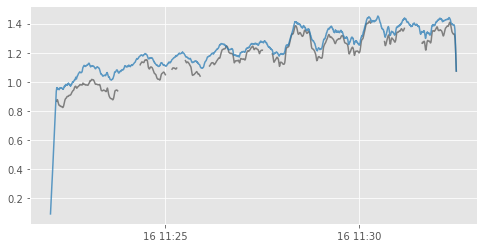

In [0]:
plt.figure(figsize=(8, 4))
plt.plot(df_rtk['speed_1Hz[m/s]'].rolling(50).mean(), color='tab:gray')
plt.plot(df_acc['speed'].rolling(500).mean(), color='tab:blue', alpha=0.7)

In [0]:
def calc_distance(x1, y1, x2, y2):
    dx = x1 - x2
    dy = y1 - y2
    distance = np.sqrt(dx**2 + dy**2)
    return distance

In [0]:
import datetime

# デッドレコニングシミュレーション
def DeadReckoning(df_acc, df_rtk, locs):
    X_mag, Y_mag, X_gyro, Y_gyro = [0.0], [0.0], [0.0], [0.0]
    last_t = df_rtk.index[0]
    last_flag = False
    direction_gyro = df_acc['angleZ[rad]'][0]
    direction_gyro_list = [direction_gyro]

    t = df_rtk.index[0]
    datetime_list = [t]
    dt = 0.2
    num = (df_acc.index[-1] - df_acc.index[0]).total_seconds() / dt
    for i in tqdm(range(int(num))):
        t += datetime.timedelta(seconds=dt)
        datetime_list.append(t)
        df_acc_part = df_acc[:t]
        df_rtk_part = df_rtk[:t]

        # df_acc_part['gyroX[rad/s]'] -= 0.16 * np.pi/180

        # 指定位置に達した場合の位置補正
        flag = False
        for loc in locs:
            distance = calc_distance(df_rtk_part['x'][-1],
                                     df_rtk_part['y'][-1], loc[0], loc[1])
            if distance < 0.3:
                flag = True
                nowloc = loc

            if last_flag == True and flag == False:
                direction_gyro = np.median(df_rtk_part['angle[rad]'][-1])
                X_mag.append(nowloc[0])
                Y_mag.append(nowloc[1])
                X_gyro.append(nowloc[0])
                Y_gyro.append(nowloc[1])
                break
    
        # 位置更新
        else:
            direction_mag = df_acc_part['angleZ[rad]'][-1]
            direction_gyro += sum(df_acc_part['gyroX[rad/s]'][last_t:]) * 0.02
            stride = df_acc_part['speed'][-1] * min(dt, 0.55)
            X_mag.append( X_mag[-1]  + stride * np.cos(direction_mag + np.pi))
            Y_mag.append( Y_mag[-1]  + stride * np.sin(direction_mag + np.pi))
            X_gyro.append(X_gyro[-1] + stride * np.cos(direction_gyro + np.pi))
            Y_gyro.append(Y_gyro[-1] + stride * np.sin(direction_gyro + np.pi))

        last_t = t
        last_flag = flag
        direction_gyro_list.append(direction_gyro)

    # データフレーム生成
    df_dr = pd.DataFrame({'datetime': datetime_list,
                          'x_mag': X_mag,
                          'y_mag': Y_mag,
                          'x_gyro': X_gyro,
                          'y_gyro': Y_gyro,
                          'gyro[rad]': direction_gyro_list})
    df_dr['datetime'] = pd.to_datetime(df_dr['datetime'])
    df_dr.set_index('datetime', inplace=True)

    return df_dr

# locs = np.array([[-2.6, -35.0], [79.1, -35.0], [40.0, -1.8], [40.0, -72.1]])
# locs = np.array([[-2.5, -35.0], [79.0, -35.0]])
# locs = np.array([[79.0, -35.0]])
locs = np.array([[-9.9, -4.0]])
# locs = np.array([])
df_dr = DeadReckoning(df_acc, df_rtk, locs)

100%|██████████| 3198/3198 [00:13<00:00, 236.97it/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


Text(0, 0.5, 'y [m]')

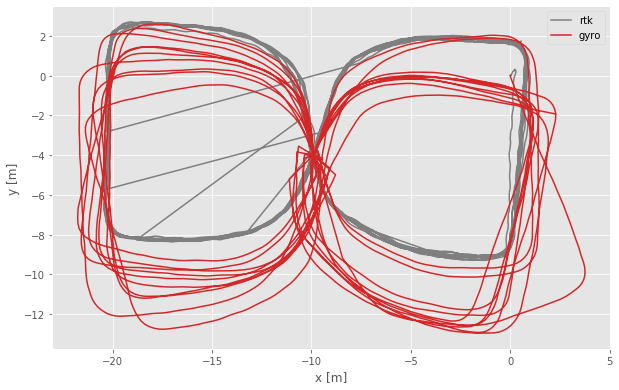

In [0]:
# 軌跡
fig = plt.figure(figsize=(10, 10))
end = df_rtk.index[-1]
plt.plot(df_rtk['x'][:end], df_rtk['y'][:end],
         color='tab:gray', label='rtk')
# plt.plot(df_gps['x'][:end], df_gps['y'][:end],
#          color='tab:green', label='gps')
# plt.plot(df_dr['x_mag'][:end], df_dr['y_mag'][:end],
#          color='tab:blue', label='mag')
plt.plot(df_dr['x_gyro'][:end], df_dr['y_gyro'][:end],
         color='tab:red', label='gyro')
plt.scatter(locs[:, 0], locs[:, 1], color='tab:brown', s=150)
plt.axes().set_aspect('equal')
plt.legend(loc='upper right')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# idx, r = 2, 1
# plt.xlim(locs[idx][0]-r, locs[idx][0]+r)
# plt.ylim(locs[idx][1]-r, locs[idx][1]+r)
# for loc in locs:
#     c = patches.Circle(xy=(loc[0], loc[1]), radius=0.3, fc='tab:brown')
#     plt.axes().add_patch(c)

# plt.xlim(-11, -9)
# plt.ylim(-5.0, -3.0)

In [0]:
print(df_rtk.query('-10.0 < x < -9.4 & -4.3 < y < -3.7')[['x','y']])

                                x         y
datetime                                   
2020-01-16 11:22:26.600 -9.727575 -4.125873
2020-01-16 11:22:26.800 -9.715257 -3.929932
2020-01-16 11:22:27.000 -9.743335 -3.742200
2020-01-16 11:23:04.200 -9.995659 -4.004491
2020-01-16 11:23:04.400 -9.926733 -3.808328
2020-01-16 11:23:43.200 -9.768967 -4.250806
2020-01-16 11:23:43.400 -9.827658 -4.074170
2020-01-16 11:23:43.600 -9.898033 -3.891320
2020-01-16 11:23:43.800 -9.940511 -3.711023
2020-01-16 11:24:20.200 -9.933625 -3.821753
2020-01-16 11:24:53.600 -9.792071 -4.237159
2020-01-16 11:24:53.800 -9.826488 -4.040995
2020-01-16 11:24:54.000 -9.867880 -3.841946
2020-01-16 11:25:27.000 -9.897667 -4.241042
2020-01-16 11:25:27.200 -9.820047 -4.015698
2020-01-16 11:25:27.400 -9.745325 -3.801116
2020-01-16 11:26:01.600 -9.773866 -4.146732
2020-01-16 11:26:01.800 -9.811725 -3.938475
2020-01-16 11:26:02.000 -9.869691 -3.734544
2020-01-16 11:26:33.000 -9.928915 -4.237048
2020-01-16 11:26:33.200 -9.86868

In [0]:
def calc_error():
    error_gyro, error_mag, error_gps = [], [], []
    for t in tqdm(df_rtk.index):
        df_rtk_part = df_rtk[:t]
        df_gps_part = df_gps[:t]
        df_dr_part  = df_dr[:t]

        distance = calc_distance(df_rtk_part['x'][-1],
                                 df_rtk_part['y'][-1],
                                 df_dr_part['x_mag'][-1],
                                 df_dr_part['y_mag'][-1])
        error_mag.append(distance)

        distance = calc_distance(df_rtk_part['x'][-1],
                                 df_rtk_part['y'][-1],
                                 df_dr_part['x_gyro'][-1],
                                 df_dr_part['y_gyro'][-1])
        error_gyro.append(distance)

        distance = calc_distance(df_rtk_part['x'][-1],
                                 df_rtk_part['y'][-1],
                                 df_gps_part['x'][-1],
                                 df_gps_part['y'][-1])
        error_gps.append(distance)

    return error_gyro, error_mag, error_gps

error_gyro, error_mag, error_gps = calc_error()

100%|██████████| 2874/2874 [00:04<00:00, 613.17it/s]


9.455608538753173


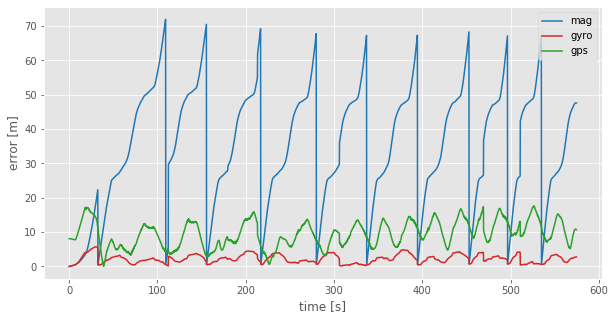

In [0]:
# 誤差
fig = plt.figure(figsize=(10, 5))
time = np.array(range(len(error_gps))) / 5
plt.plot(time, error_mag, color='tab:blue', label='mag')
plt.plot(time, error_gyro, color='tab:red', label='gyro')
plt.plot(time, error_gps, color='tab:green', label='gps')
plt.xlabel('time [s]')
plt.ylabel('error [m]')
plt.legend(loc='upper right')

print(np.mean(error_gps))

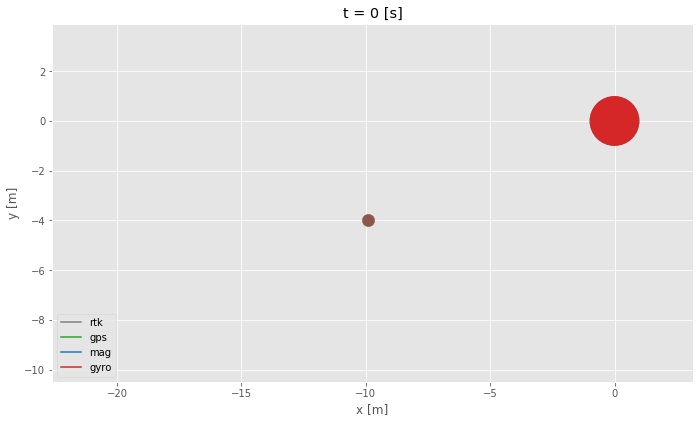

In [0]:
# アニメーション作成
import matplotlib.animation as animation
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 10))

l_rtk,  = ax.plot([], [], color='tab:gray',  label='rtk')
l_gps,  = ax.plot([], [], color='tab:green', label='gps')
l_mag,  = ax.plot([], [], color='tab:blue',  label='mag')
l_gyro, = ax.plot([], [], color='tab:red',   label='gyro')

c_rtk  = patches.Circle(xy=(df_rtk['x'][0], df_rtk['y'][0]),
                        radius=1, fc='tab:gray')
# c_gps  = patches.Circle(xy=(df_gps['x'][0], df_gps['y'][0]),
#                         radius=1, fc='tab:green')
# c_mag  = patches.Circle(xy=(df_dr['x_mag'][0], df_dr['y_mag'][0]),
#                         radius=1, fc='tab:blue')
c_gyro = patches.Circle(xy=(df_dr['x_gyro'][0], df_dr['y_gyro'][0]),
                        radius=1, fc='tab:red')
ax.add_patch(c_rtk)
# ax.add_patch(c_gps)
# ax.add_patch(c_mag)
ax.add_patch(c_gyro)

plt.scatter(locs[:, 0], locs[:, 1], color='tab:brown', s=150)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
# ax.set_xlim(-40, 100)
# ax.set_ylim(-100, 40)
# ax.set_xlim(-25, 5)
# ax.set_ylim(-25, 5)
blank_x = (max(df_rtk['x']) - min(df_rtk['x'])) * 0.1
blank_y = (max(df_rtk['y']) - min(df_rtk['y'])) * 0.1
ax.set_xlim(min(df_rtk['x']) - blank_x, max(df_rtk['x']) + blank_x)
ax.set_ylim(min(df_rtk['y']) - blank_y, max(df_rtk['y']) + blank_y)
ax.set_aspect('equal')
ax.legend(loc='lower left')
plt.subplots_adjust(left=0.08, right=0.97, bottom=0.04, top=0.97)


def update(i):
    end = df_rtk.index[0] + datetime.timedelta(seconds=i)

    plt.title('t = {} [s]'.format(i))
    
    df_rtk_part = df_rtk[:end]
    df_gps_part = df_gps[:end]
    df_dr_part = df_dr[:end]

    l_rtk.set_data(df_rtk_part['x'], df_rtk_part['y'])
    # l_gps.set_data(df_gps_part['x'], df_gps_part['y'])
    # l_mag.set_data(df_dr_part['x_mag'], df_dr_part['y_mag'])
    l_gyro.set_data(df_dr_part['x_gyro'], df_dr_part['y_gyro'])
    
    c_rtk.set_center([df_rtk_part['x'][-1], df_rtk_part['y'][-1]])
    # c_gps.set_center([df_gps_part['x'][-1], df_gps_part['y'][-1]])
    # c_mag.set_center([df_dr_part['x_mag'][-1], df_dr_part['y_mag'][-1]])
    c_gyro.set_center([df_dr_part['x_gyro'][-1], df_dr_part['y_gyro'][-1]])


ani = animation.FuncAnimation(fig, update, interval=100, frames=700)

from IPython.display import HTML
HTML(ani.to_html5_video())

MovieWriter imagemagic unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


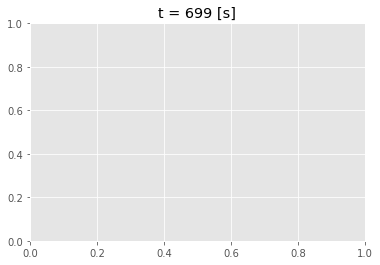

In [0]:
# アニメーション保存
ani.save('graph/DeadReckoning.gif', writer='imagemagic')
ani.save('graph/DeadReckoning.mp4', writer='ffmpeg')

In [0]:
# import copy

# class Particle():
#     def __init__(self, pose, weight):
#         self.pose = copy.deepcopy(pose)
#         self.weight = weight

#     def update_pose(self, distance, direction, omega, dt):
#         distance += np.random.normal(0, 0.1**2)
#         direction += np.random.normal(0, (10 * np.pi/180)**2)
#         self.pose['x'] += distance * np.cos(direction) * dt
#         self.pose['y'] += distance * np.sin(direction) * dt
#         self.pose['theta'] += omega * dt

#     def update_weight(self, x, y, var):
#         mean = [x, y]
#         cov = np.diag([var, var])
#         rv = multivariate_normal(mean, cov)
#         self.weight *= rv.pdf((self.pose['x'], self.pose['y']))

In [0]:
# from scipy.stats import multivariate_normal

# class ParticleFilter():
#     def __init__(self, pose, num):
#         self.particles = [Particle(pose, 1/num) for i in range(num)]
#         self.pose = pose

#         self.particles_log = []
#         self.pose_log = []
#         self.time_log = []

#     def _update_pose(self, stride, angle, omega, dt, var=10.0):
#         for p in self.particles: p.update_pose(stride, angle, omega, dt)

#     def _update_weight(self, gps_x, gps_y, var=10.0):
#         for p in self.particles: p.update_weight(gps_x, gps_y, var)

#     def _set_pose(self):
#         i = np.argmax([p.weight for p in self.particles])
#         self.pose = self.particles[i].pose

#     def _resampling(self):
#         ws = np.cumsum([p.weight for p in self.particles])
#         if ws[-1] < 1e-100: ws = [e + 1e-100 for e in ws]

#         step = ws[-1] / len(self.particles)
#         r = np.random.uniform(0.0, step)
#         cur_pos = 0
#         particles_tmp = []

#         while len(particles_tmp) < len(self.particles):
#             if r < ws[cur_pos]:
#                 particles_tmp.append(self.particles[cur_pos])
#                 r += step
#             else:
#                 cur_pos += 1
                
#         self.particles = particles_tmp.copy()
#         for p in self.particles: p.weight = 1.0/len(self.particles)

#     def particleFilter(self, df_acc, df_gps, df_rtk):
#         last_t = df_acc.index[0]
#         for t in tqdm(df_acc.index):
#             self._update_pose(df_acc['speed'][t]/10,
#                               df_acc['angleZ[rad]'][t] + np.pi,
#                               ld.rad2deg(df_acc['gyroX[deg/s]'][t]),
#                               (t - last_t).total_seconds())

#             df_gps_part = df_gps[last_t:t]
#             if len(df_gps_part) != 0:
#                 self._update_weight(df_gps_part['x'][-1], df_gps_part['y'][-1])
#                 self._set_pose()
#                 self._resampling()

#             self.particles_log.append(copy.deepcopy(self.particles))
#             self.pose_log.append(copy.deepcopy(self.pose))
#             self.time_log.append(t)

#             last_t = t

#     def _update_animation(self, i):
#         Hz, seconds = 5, 1
#         idx = min(i * Hz * seconds, df_rtk.shape[0]-1)
#         end = df_rtk.index[idx]
#         # seconds = 0.02
#         plt.title('t = {:.2f} [s]'.format(i * seconds))
        
#         df_rtk_part = df_rtk[:end]

#         x = [pose['x'] for pose in pf.pose_log]
#         y = [pose['y'] for pose in pf.pose_log]
#         self.l_pf.set_data(x[:i*50], y[:i*50])
#         self.l_rtk.set_data(df_rtk_part['x'], df_rtk_part['y'])

#         # self.c_pf.set_center([x[:i], y[:i]])

#         # 前回のフレーム内容を一旦削除
#         if len(self.im) > 0:
#             self.im[0].remove()
#             self.im.pop()

#         x = [p.pose['x'] for p in self.particles_log[i]]
#         y = [p.pose['y'] for p in self.particles_log[i]]
#         self.im.append(plt.scatter(x, y, color='tab:orange'))

#     def animation(self):
#         fig, ax = plt.subplots(figsize=(10, 10))

#         self.l_pf, = ax.plot([], [], color='tab:orange', label='pf')
#         self.l_rtk,  = ax.plot([], [], color='tab:gray',  label='rtk')

#         # self.c_pf = patches.Circle(radius=1, fc='tab:orange',
#         #                 xy=(self.pose_log[0]['x'], self.pose_log[0]['y']))
#         # ax.add_patch(self.c_pf)

#         ax.set_xlim(-20, 80)
#         ax.set_ylim(-80, 20)
#         ax.set_aspect('equal')
#         ax.legend(loc='lower left')
#         plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

#         self.im = [] # フレーム更新の際に前回のプロットを削除するために用意

#         self.ani = animation.FuncAnimation(fig, self._update_animation,
#                                            interval=100, frames=50 * 30)

In [0]:
# # パーティクルフィルタ実行
# init_pose = {'x': 0.0, 'y': 0.0, 'theta': 0.0}
# end = df_acc.index[50 * 600]
# pf = ParticleFilter(init_pose, 10)
# pf.particleFilter(df_acc[:end], df_gps[:end], df_rtk[:end])

  0%|          | 0/30001 [00:00<?, ?it/s]


AttributeError: ignored

In [0]:
# # 軌跡
# fig = plt.figure(figsize=(10, 10))
# end = df_rtk.index[5 * 60 * 11]
# plt.plot(df_rtk['x'][:end], df_rtk['y'][:end],
#          color='tab:gray', label='rtk')
# plt.plot(df_gps['x'][:end], df_gps['y'][:end],
#          color='tab:green', label='gps')
# plt.plot(df_dr['x_mag'][:end], df_dr['y_mag'][:end],
#          color='tab:blue', label='mag')
# plt.plot(df_dr['x_gyro'][:end], df_dr['y_gyro'][:end],
#          color='tab:red', label='gyro')

# x = np.array([pose['x'] for pose in pf.pose_log])
# y = np.array([pose['y'] for pose in pf.pose_log])
# plt.plot(x, y, color='tab:orange', label='mcl')

# plt.axes().set_aspect('equal')
# plt.legend(loc='upper right')

In [0]:
# # アニメーション
# pf.animation()

# from IPython.display import HTML
# HTML(pf.ani.to_html5_video())